In [1]:
#Written by Lehan Yao; Modified by Jiahui Li
#This is for identifying particle position in SEM image and calculating the lattice parameter and offset.

In [49]:
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename() #analyzing figure
temp_path = filedialog.askopenfilename() #template by imageJ
contour_path = filedialog.askopenfilename() #contour of template; multipoint; csv; only for plotting

In [50]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt
from skimage.feature import peak_local_max
import pandas as pd

#read the file and template
I = cv2.imread(file_path)
temp = cv2.imread(temp_path)
contour = pd.read_csv(contour_path)
contour = contour.to_numpy()[:,1:3]
center = contour.mean(0)
M = cv2.moments(contour.astype('float32'))
cx = M['m10']/M['m00']
cy = M['m01']/M['m00']
center = np.array([cx,cy])
print(center)

[52.84395231 62.01261288]


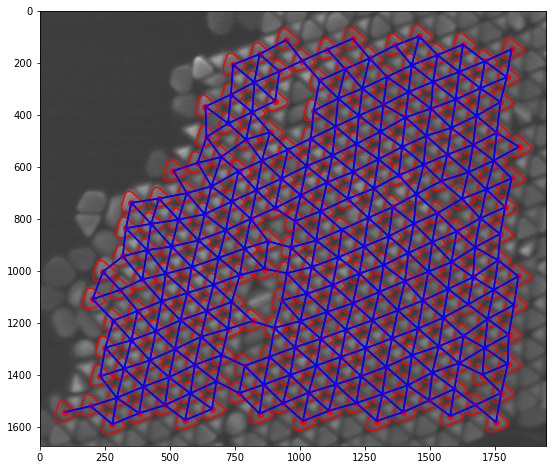

In [51]:
#template matching and connecting particle
res = cv2.matchTemplate(I,temp,cv2.TM_CCOEFF_NORMED)
latticeconstant = [0, 120] #range 
xy = peak_local_max(res, min_distance=30, threshold_abs = 0.55) #min_distance can be implied by handmeasuring lattice constant
xy = xy+center[::-1]

plt.figure(figsize = (12,8))
plt.imshow(I)
vecs = []
for locs in xy:
    plt.scatter(locs[1],locs[0],color = 'red')
    plt.plot(contour[:,0]-center[0]+locs[1],contour[:,1]-center[1]+locs[0],'red')
    for locs2 in xy:
        dist = np.linalg.norm(locs-locs2,2)
        if(np.logical_and(dist<latticeconstant[1], dist>latticeconstant[0])): 
            plt.plot([locs[1],locs2[1]],[locs[0],locs2[0]],'blue')
            vec = locs2-locs
            vecs.append(vec)

In [45]:
scale = (641-36)/500 
#px/nm normalize size

vecs = np.array(vecs)/scale
contour = contour/scale
center = center/scale

#the mean orientation of three corners of tetrahedra with horizontal direction
orientation_mean = 115.2353333

120.96125076154803
0
-3.582032307512959
0.5748482684640596
2
0.6067578972734319
-119.47355825974887
1
-1.4876372051197635
Lattice constant:  89.42573059521452 nm;  std 0.27581591391915106 offset angle:  34.07715310991227 degrees. std 0.19456760140152415


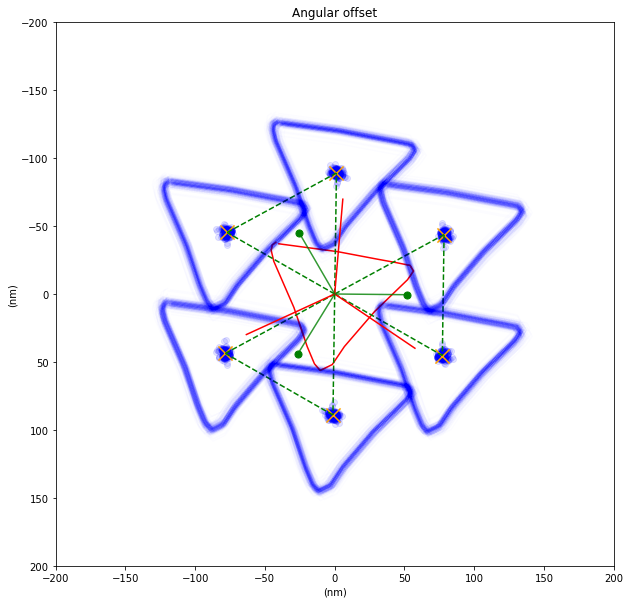

In [48]:
from sklearn.mixture import GaussianMixture
vecs = np.array(vecs)
f,ax = plt.subplots(figsize = (10,10))
ax.plot(contour[:,0]-center[0],contour[:,1]-center[1],color= 'red')
ax.scatter(vecs[:,1],vecs[:,0],color='blue',alpha=.1)

NNs =  GaussianMixture(n_components=6,random_state=1) #separate into six clusters
NNs.fit(vecs)
means = NNs.means_
d = np.linalg.norm(means,2,1)
d_std = np.std(d)
d_mean = np.mean(d)
ax.scatter(means[:,1],means[:,0],marker='x',color='orange',s = 200)

little_triangle_1 = np.vstack([np.array([0,0]),means[0,:],means[5,:]])###changes the number in mean until black triangle in void
little_triangle_1 = np.mean(little_triangle_1,0)

plt.plot([means[0,1],means[5,1]],[means[0,0],means[5,0]],color='green',linestyle='dashed')

little_triangle_2 = np.vstack([np.array([0,0]),means[1,:],means[4,:]])###changes the number in mean until black triangle in void
little_triangle_2 = np.mean(little_triangle_2,0)

plt.plot([means[1,1],means[4,1]],[means[1,0],means[4,0]],color='green',linestyle='dashed')

little_triangle_3 = np.vstack([np.array([0,0]),means[2,:],means[3,:]])###changes the number in mean until black triangle in void
little_triangle_3 = np.mean(little_triangle_3,0)

plt.plot([means[2,1],means[3,1]],[means[2,0],means[3,0]],color='green',linestyle='dashed')

plt.plot([0,means[0,1]],[0,means[0,0]],color='green',linestyle='dashed')
plt.plot([0,means[2,1]],[0,means[2,0]],color='green',linestyle='dashed')
plt.plot([0,means[3,1]],[0,means[3,0]],color='green',linestyle='dashed')
plt.plot([0,means[5,1]],[0,means[5,0]],color='green',linestyle='dashed')
plt.plot([0,means[1,1]],[0,means[1,0]],color='green',linestyle='dashed')
plt.plot([0,means[4,1]],[0,means[4,0]],color='green',linestyle='dashed')

ax.scatter(little_triangle_1[1],little_triangle_1[0],marker='.',color = 'green', s=200) #red
ax.scatter(little_triangle_2[1],little_triangle_2[0],marker='.',color = 'green', s=200) #green
ax.scatter(little_triangle_3[1],little_triangle_3[0],marker='.',color = 'green', s=200) #blue
little_triangles = np.vstack([little_triangle_1,little_triangle_2,little_triangle_3])
thetas = []
for row in vecs:
    ax.plot(contour[:,0]-center[0]+row[1],contour[:,1]-center[1]+row[0],color= 'blue',alpha = .01)
tips = [-orientation_mean-90,-orientation_mean+30,-orientation_mean+150]
for xy in little_triangles:
    x = xy[1]
    y = xy[0]
    orientation = np.degrees(np.arctan2(y,x))
    print(orientation)
    greenx = xy[1]
    greeny = xy[0]
    diffs = []
    for degree in tips:
        degree = np.deg2rad(degree)
        x = np.cos(degree)
        y = np.sin(degree)
        orientation_c =np.degrees(np.arctan2(y,x))
        diffs.append(orientation_c-orientation)
    diffs_mod = np.array([x%360 for x in diffs])

    idx = np.argmin(np.abs(diffs_mod))
    print(idx)
    thetas.append(diffs_mod[idx])
    
    degree = tips[idx] 
    
    degree = np.deg2rad(degree)
    print(degree)
    x = np.cos(degree)*70
    y = np.sin(degree)*70
    ax.plot([0,x],[0,y],color='red')
    ax.plot([0,greenx],[0,greeny],color = 'green', alpha = .8)
    
disppx = 200
ax.set_xlim((-disppx,disppx))
ax.set_ylim((disppx,-disppx))
ax.set_title('Angular offset')
ax.set_xlabel('(nm)')
ax.set_ylabel('(nm)')
theta_mean = np.mean(thetas)
theta_std = np.std(thetas)
print('Lattice constant: ',str(d_mean),'nm; ', 'std', str(d_std), 'offset angle: ',str(theta_mean),'degrees.', 'std', str(theta_std))

Text(0.5, 0, 'matching score')

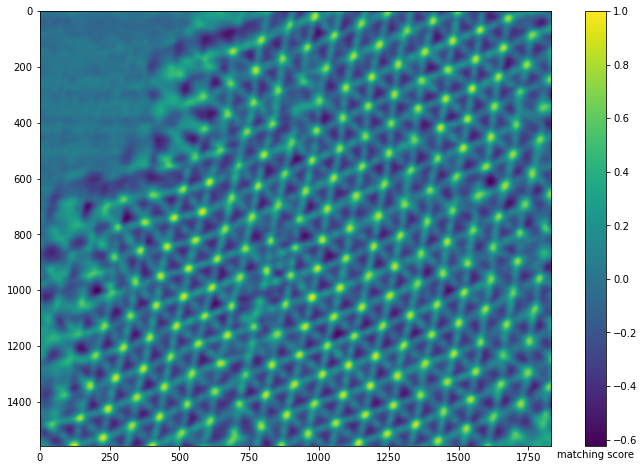

In [4]:
#check the matching score over the whole image
plt.figure(figsize = (12,8))
h = plt.imshow(res)
cb = plt.colorbar(h)
cb.ax.set_xlabel('matching score')

In [37]:
#calulating the offset standard deviation and export
def angular_dif(vec,cen_vec):
    o_c = np.degrees(np.arctan2(cen_vec[1],cen_vec[0])) ##-180 : 180
    o = np.degrees(np.arctan2(vec[:,1],vec[:,0]))   ##-180 : 180
    #print(o)
    dif = np.mod(abs(o_c-o),360)
    signs = np.sign(o_c-o)
    dif = [x if (x<=180) else 360-x for x in dif ]
    dif = signs*np.array(dif) ##difference without sign
    
    return dif
GMM_class = NNs.predict(vecs)
diffs_all = []
for m in set(GMM_class):
    vec_m = vecs[GMM_class==m,:]
    vec_c = means[m]
    diffs = angular_dif(vec_m,vec_c)
    diffs_all.append(diffs)
diffs_all = np.concatenate( diffs_all, axis=0 )
vec_d = np.linalg.norm(vecs,2,1)

save_path = filedialog.asksaveasfilename() #save csv
savetxt(save_path, diffs_all, delimiter=',')
print('Lattice constant: ',"{:.2f}".format(d_mean),'+-',"{:.2f}".format(np.std(vec_d)),'nm; ', 'offset angle: ',"{:.2f}".format(theta_mean),'+-',"{:.2f}".format(np.std(diffs_all)),'degrees.')

Lattice constant:  89.43 +- 1.81 nm;  offset angle:  34.08 +- 1.27 degrees.
